# Import data

In [1]:
import gdown 

url = 'https://drive.google.com/uc?id=1CxOcvyFlx2V-8ubpRuVZclOBUYFPe_t6'
output = 'MLTollsStackOverflow.csv'
gdown.download(url, output)                                                                  

Downloading...
From: https://drive.google.com/uc?id=1CxOcvyFlx2V-8ubpRuVZclOBUYFPe_t6
To: /Users/okara/Downloads/Data-science-master/time_series/kats_examples/MLTollsStackOverflow.csv
100%|█████████████████████████████████████████████████████████████████████████████████████████| 30.5k/30.5k [00:00<00:00, 21.9MB/s]


'MLTollsStackOverflow.csv'

Error processing line 3 of /usr/local/Cellar/python@3.9/3.9.9/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/googleapis_common_protos-1.54.0-py3.10-nspkg.pth:

  Traceback (most recent call last):
    File "/usr/local/Cellar/python@3.9/3.9.9/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site.py", line 169, in addpackage
      exec(line)
    File "<string>", line 1, in <module>
    File "<frozen importlib._bootstrap>", line 562, in module_from_spec
  AttributeError: 'NoneType' object has no attribute 'loader'

Remainder of file ignored


In [2]:
import pandas as pd

In [3]:
df = pd.read_csv("MLTollsStackOverflow.csv")

In [4]:
df["month"] = pd.to_datetime(df["month"], format="%y-%b")
df = df.set_index("month")

In [5]:
python = df["python"].to_frame()

In [6]:
train_len = 102
train = python.iloc[:train_len]
test = python.iloc[train_len:]

# Turn Data into Time Series

In [9]:
# !pip install kats
# !pip install localpip 
# !localpip install fbprophet
from kats.consts import TimeSeriesData

In [10]:
ts = TimeSeriesData(train.reset_index(), time_col_name="month")


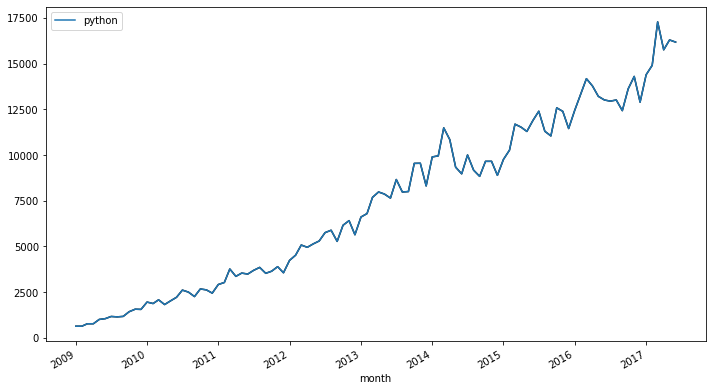

In [11]:
ts.plot(cols=["python"])

# Forecasting

## Facebook Prophet

In [12]:
from kats.models.prophet import ProphetModel, ProphetParams

params = ProphetParams(seasonality_mode="multiplicative")
m = ProphetModel(ts, params)

In [13]:
m.fit()

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -2.30254
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       316.886   0.000440502       66.4183           1           1      128   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       318.296   2.71913e-05       69.8324      0.1887      0.1887      254   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     217       318.639    0.00159886       301.237    1.49e-05       0.001      304  LS failed, Hessian reset 
     299       318.894   4.77837e-08       60.8281      0.2742      0.6544      417   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     335       318.896   1.66229e-05         60.57   3.057e-07       0.001      521  LS failed, Hessian reset 
     372       318.898   9.06742e-09       69.1743      0.1216      0.1216      573   
Optimization terminat

In [14]:
fcst = m.predict(steps=30, freq="MS")

In [15]:
fcst.head()

,time,fcst,fcst_lower,fcst_upper
0,2017-07-01,15722.239484,15177.449718,16208.397016
1,2017-08-01,15069.894371,14549.656819,15550.897630
2,2017-09-01,14369.703088,13848.440160,14912.400286
3,2017-10-01,16003.609229,15499.840296,16513.081508
4,2017-11-01,16267.547332,15741.047560,16785.211333


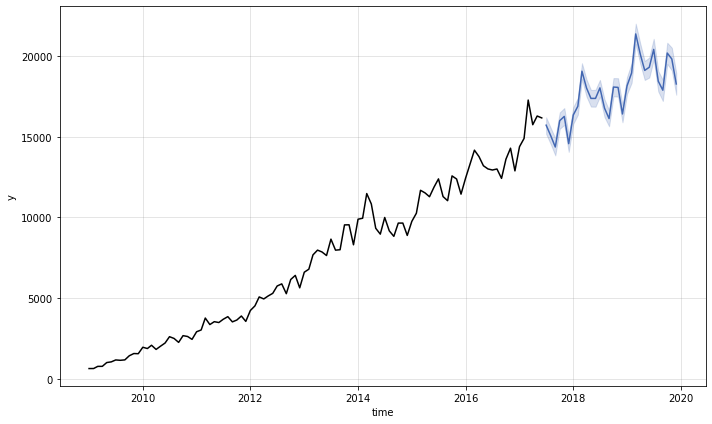

In [16]:
m.plot()

In [17]:
import matplotlib.pyplot as plt

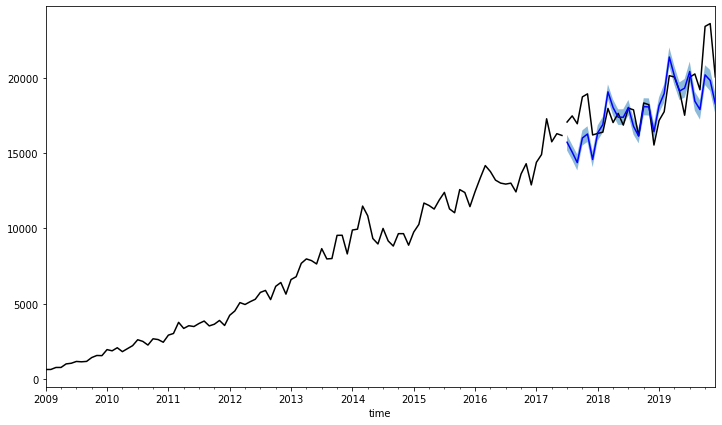

In [18]:
fig, ax = plt.subplots(figsize=(12, 7))
train.plot(ax=ax, label="train", color="black")
test.plot(ax=ax, color="black")
fcst.plot(x="time", y="fcst", ax=ax, color="blue")
ax.fill_between(test.index, fcst["fcst_lower"], fcst["fcst_upper"], alpha=0.5)
ax.get_legend().remove()

## Holt-Winters

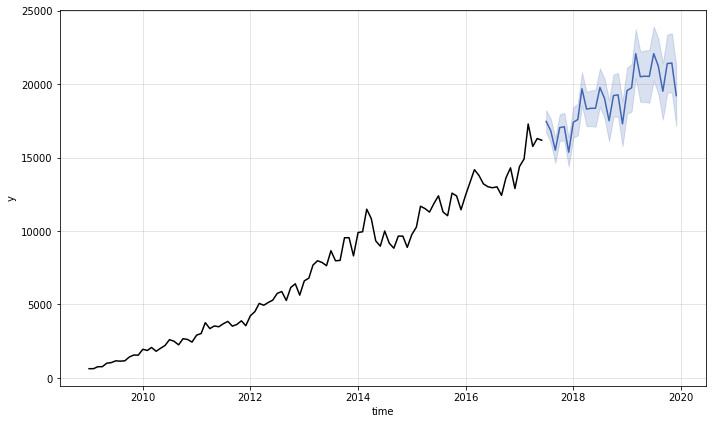

In [19]:
from kats.models.holtwinters import HoltWintersParams, HoltWintersModel
import warnings
warnings.simplefilter(action='ignore')

params = HoltWintersParams(
            trend="add",
            seasonal="mul",
            seasonal_periods=12,
        )
m = HoltWintersModel(
    data=ts, 
    params=params)

m.fit()
fcst = m.predict(steps=30, alpha = 0.1)
m.plot()


# Detect change point

In [20]:
from IPython.core.pylabtools import figsize

In [21]:
from kats.consts import TimeSeriesData, TimeSeriesIterator
from kats.detectors.cusum_detection import CUSUMDetector
import matplotlib.pyplot as plt

In [22]:
figsize(15, 7)

The change point is on 2013-02-01 00:00:00


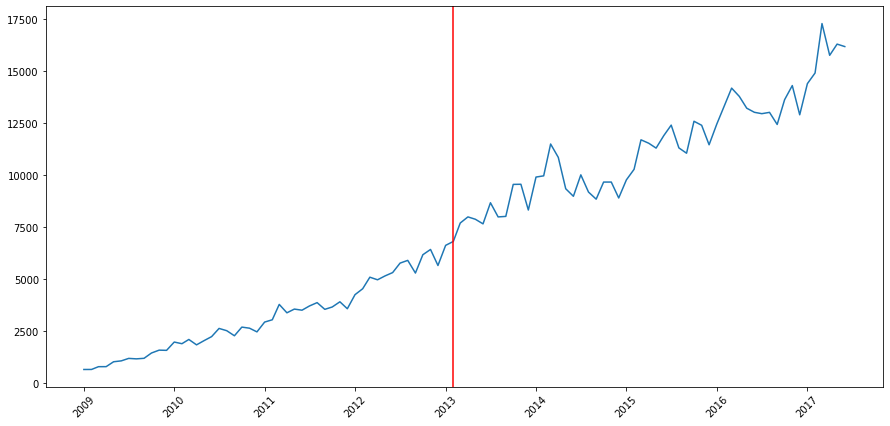

In [23]:
detector = CUSUMDetector(ts)

change_points = detector.detector(change_directions=["increase", "decrease"])

for change_point in change_points:
    print("The change point is on", change_point[0].start_time)

# plot the results
plt.xticks(rotation=45)
detector.plot(change_points)
plt.show()

In [24]:
def get_ts(topic: str):
    return TimeSeriesData(df[topic].to_frame().reset_index(), time_col_name="month")

In [25]:
def detect_change_point(topic: str):
    ts = get_ts(topic)
    detector = CUSUMDetector(ts)

    change_points = detector.detector()
    for change_point in change_points:
        print("The change point is on", change_point[0].start_time)

    # plot the results
    plt.xticks(rotation=45)
    detector.plot(change_points)
    plt.show()

The change point is on 2015-12-01 00:00:00


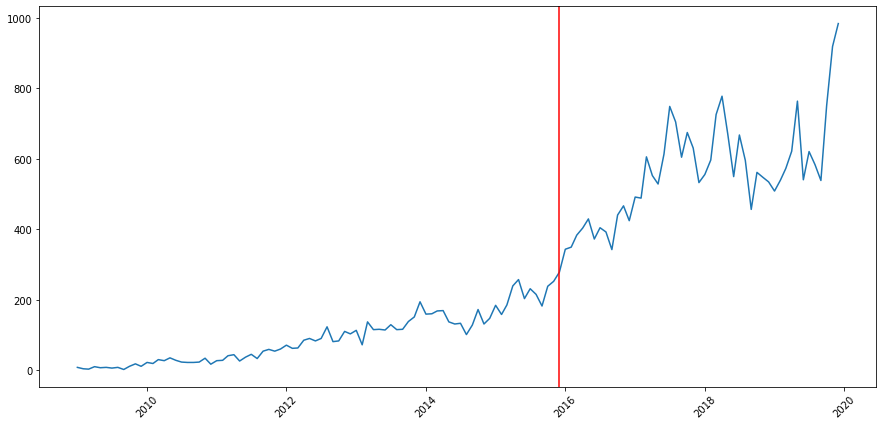

In [26]:
detect_change_point("machine-learning")

The change point is on 2015-11-01 00:00:00


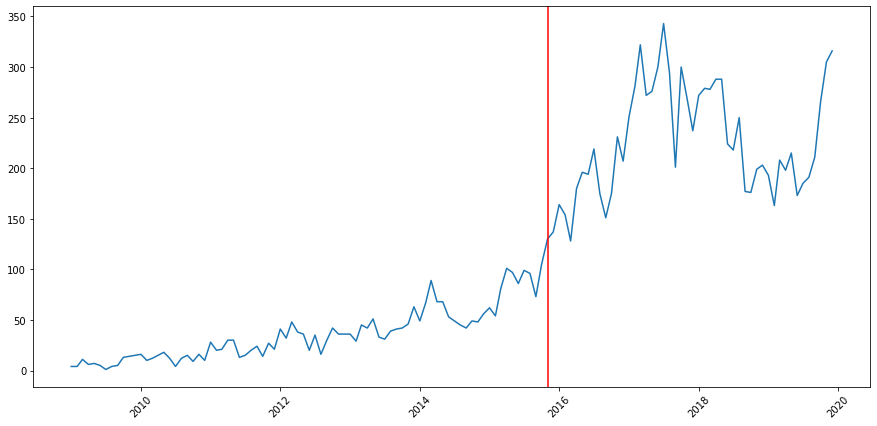

In [27]:
detect_change_point("neural-network")

The change point is on 2016-09-01 00:00:00


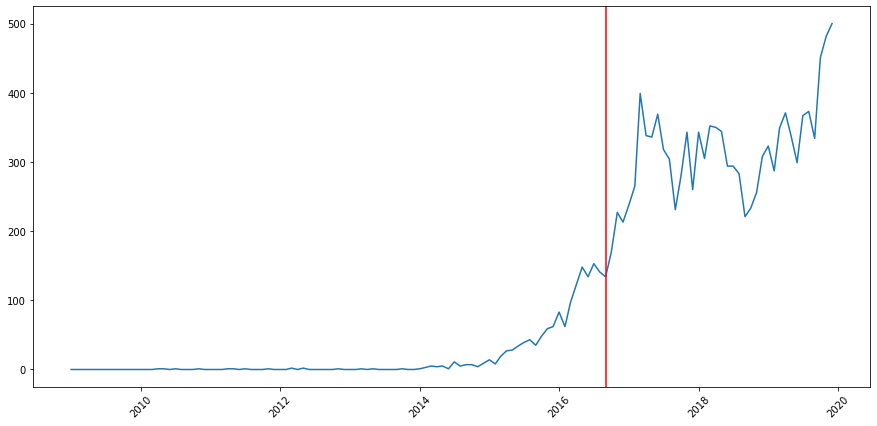

In [28]:
detect_change_point("deep-learning")

The change point is on 2015-07-01 00:00:00


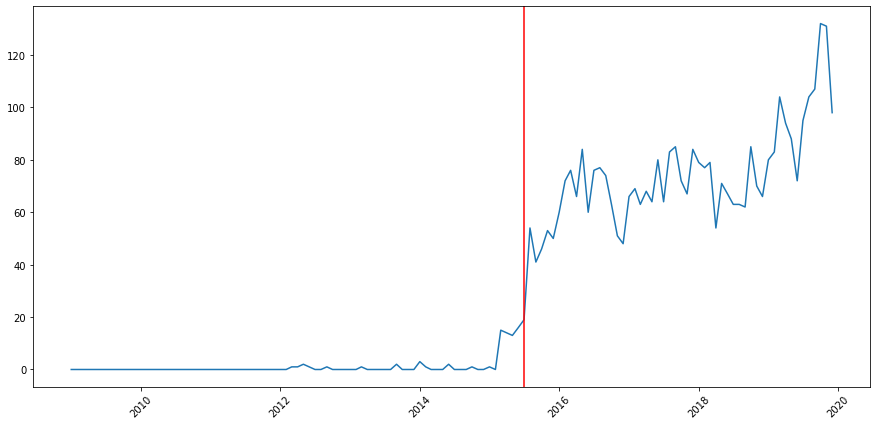

In [29]:
detect_change_point("jupyter")

The change point is on 2016-02-01 00:00:00


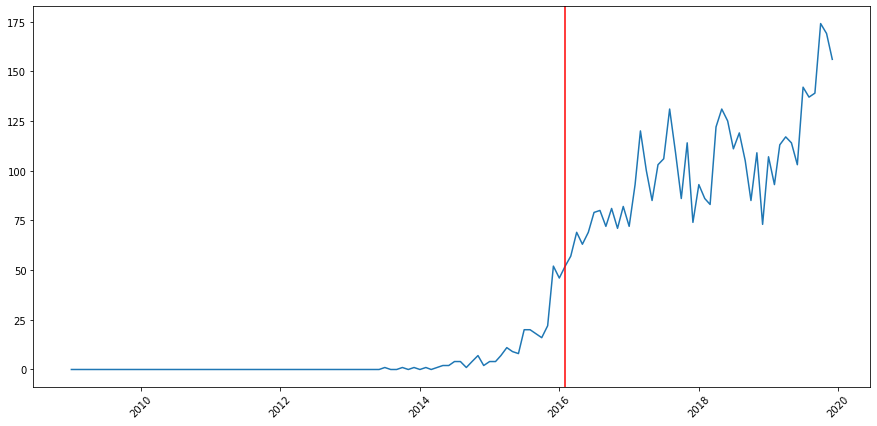

In [30]:
detect_change_point("plotly")

The change point is on 2017-02-01 00:00:00


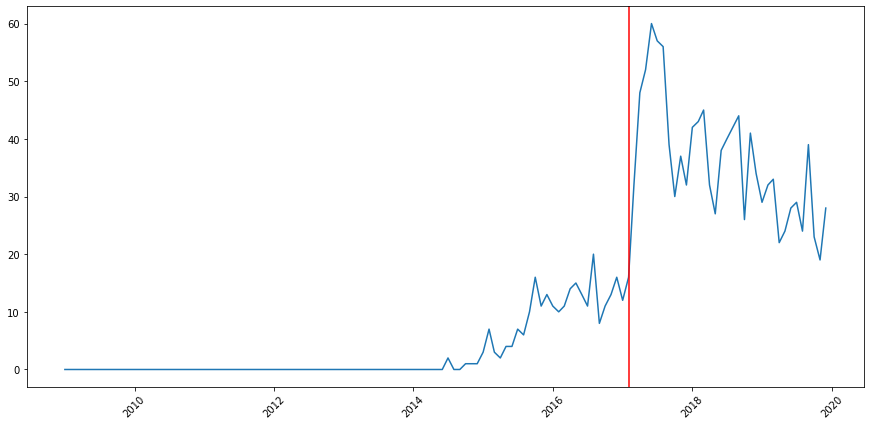

In [31]:
detect_change_point("H2o")

The change point is on 2016-12-01 00:00:00


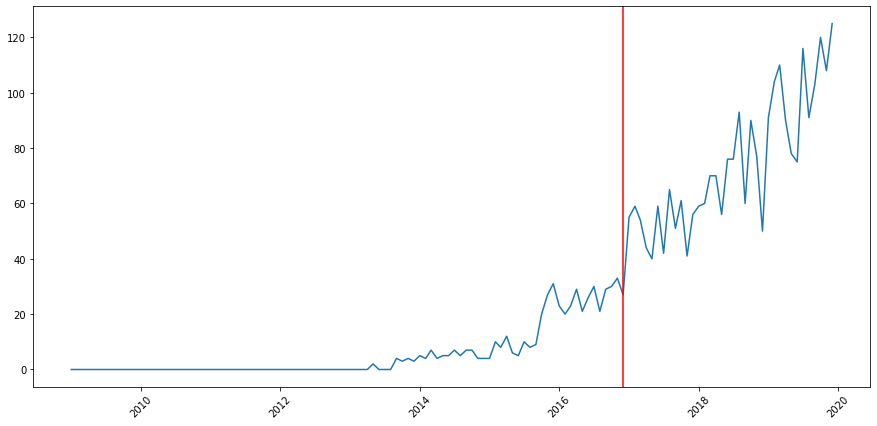

In [32]:
detect_change_point("Colab")

# Outlier Detection

<AxesSubplot:xlabel='month'>

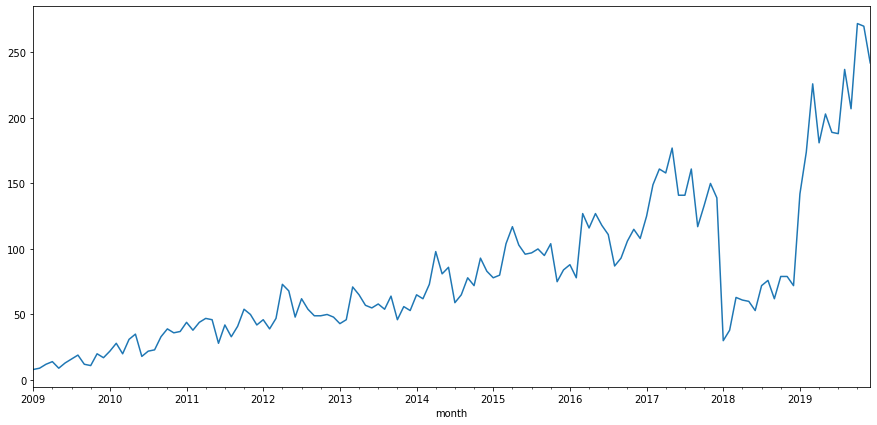

In [34]:
df["nlp"].plot()

In [35]:
ts = get_ts("nlp")

In [36]:
from kats.detectors.outlier import OutlierDetector

ts_outlierDetection = OutlierDetector(ts, "additive")
ts_outlierDetection.detector()

In [40]:
outlier_range1 = ts_outlierDetection.outliers[0]
print(f"The outliers range from {outlier_range1[0]} to {outlier_range1[1]}")

The outliers range from 2018-01-01 00:00:00 to 2019-03-01 00:00:00


# Time Series Features

In [41]:
ts

,month,nlp
0,2009-01-01,8
1,2009-02-01,9
2,2009-03-01,12
3,2009-04-01,14
4,2009-05-01,9
...,...,...
127,2019-08-01,237
128,2019-09-01,207
129,2019-10-01,272
130,2019-11-01,270


In [42]:
from kats.tsfeatures.tsfeatures import TsFeatures

model = TsFeatures()

output_features = model.transform(ts)
output_features

TypeError: acf() got an unexpected keyword argument 'unbiased'